# Example code to draw magnetic field maps and scientific plots from the IGRF-14 

Load in IGRF-14 coefficients
#
There are : 
- first two lines start with # with comments/metadata 
- third line: cosine/sine degree and order  DGRF or IGRF or SV
- fourth line: g/h n m year  
- data starts on figth line e.g.:  g 1  0 -31543 ... 

0) Load in coefficients
1) Lowes-Maursberger power spectra plot
2) Maps magnetic field in: X, Y, Z, Dec, Inc, H, F 
3) Plot of Dipole axial changes

In [1]:
# Import the packages and bespoke functions from src folder
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import shapefile  # from package pyshp >= 2.3.1, pip install pyshp
shp = os.path.abspath('../data/external/ne_110m_coastline.zip')

from src import sha_lib as shal
from src import shc_utils as shau

# Set up line colour/type/marker properties using cycler
from cycler import cycler
cc = ( cycler(linestyle=['-', '--', '-.',':']) *
       cycler(color=list('rgbk')) *
       cycler(marker=['none', 's', '.']))

## Configure input

User sets the following variables:

In [2]:
# Access SHC model in the ../data/release directory


SHC_FILE = os.path.abspath('../data/release/IGRF14.shc')

In [3]:
"""

Load in the coefficients 

"""

# Load in the IGRF14 coefficients
[time, coeffs, parameters] = \
         shau.load_shcfile(SHC_FILE)

degree = parameters['nmax']

## Power spectra

Text(0.5, 1.0, 'Mausberger-Lowes Spectrum for IGRF-14 models')

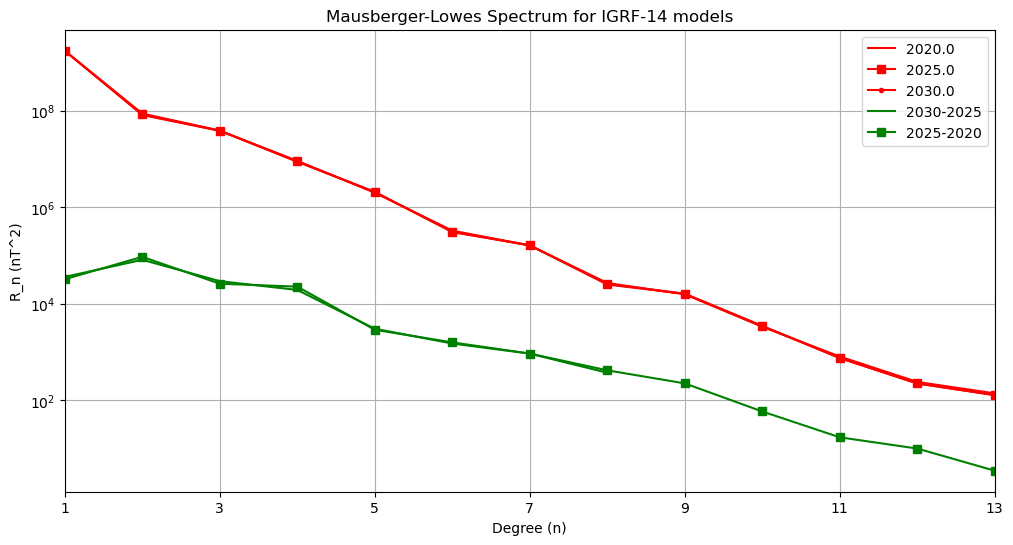

In [4]:
"""

First Test: plot of power spectra of each model on a log plot (n versus Rn)

"""

# Set up figure and line colour/type using cycler
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_prop_cycle(cc)

# Place the Rn values and institute names in a dictionary
# Plot the most recent spectra
Rn = []
for i in range(len(time)-3,len(time)):
    Rn.append(shau.msum(coeffs[:,i], degree)*np.arange(2,degree+2))

# Plot differences to the previous model
Rn.append(shau.msum(coeffs[:,-1]-coeffs[:,-2], degree)*np.arange(2,degree+2))
Rn.append(shau.msum(coeffs[:,-2]-coeffs[:,-3], degree)*np.arange(2,degree+2))

labels = list(map(str,time[-3:]))
labels.append('2030-2025')
labels.append('2025-2020')

spectra = dict(zip(labels, Rn))

# Plotting the lines with labels
for label, y in spectra.items():
   # Replace zero with NaN 
   if np.any(y == 0):
        y = np.where(y==0, np.nan, y)
   ax.semilogy(np.arange(1, degree+1), y, label = label)
# Adding legend, x and y labels, and title for the lines
ax.legend()
plt.xlabel('Degree (n)')
plt.ylabel('R_n (nT^2)')
ax.grid()
plt.xticks(np.arange(1, degree+1,2))
plt.xlim(1,degree)
plt.title('Mausberger-Lowes Spectrum for IGRF-14 models')

## Magnetic field maps

axes 0 0: X
axes 1 1: D
axes 2 2: Y


axes 3 3: I
axes 4 4: Z
axes 5 5: F
axes 6 6: H


axes 0 0: X
axes 1 1: D
axes 2 2: Y
axes 3 3: I


axes 4 4: Z
axes 5 5: F
axes 6 6: H


axes 0 0: X
axes 1 1: D
axes 2 2: Y
axes 3 3: I


axes 4 4: Z
axes 5 5: F
axes 6 6: H


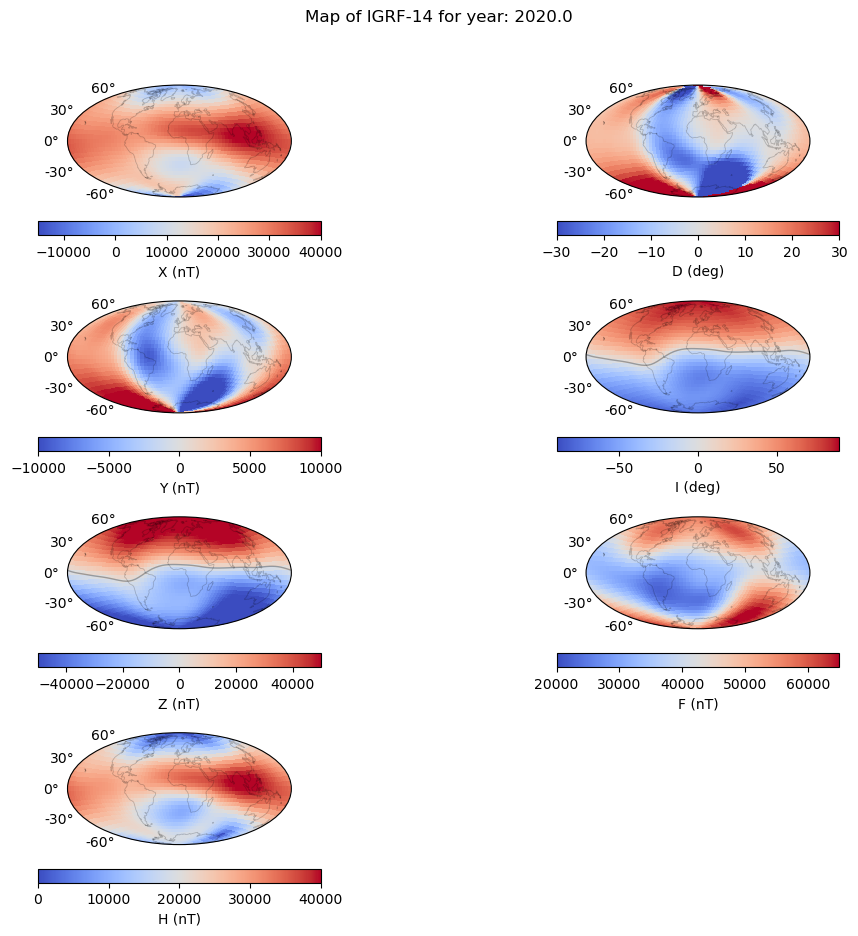

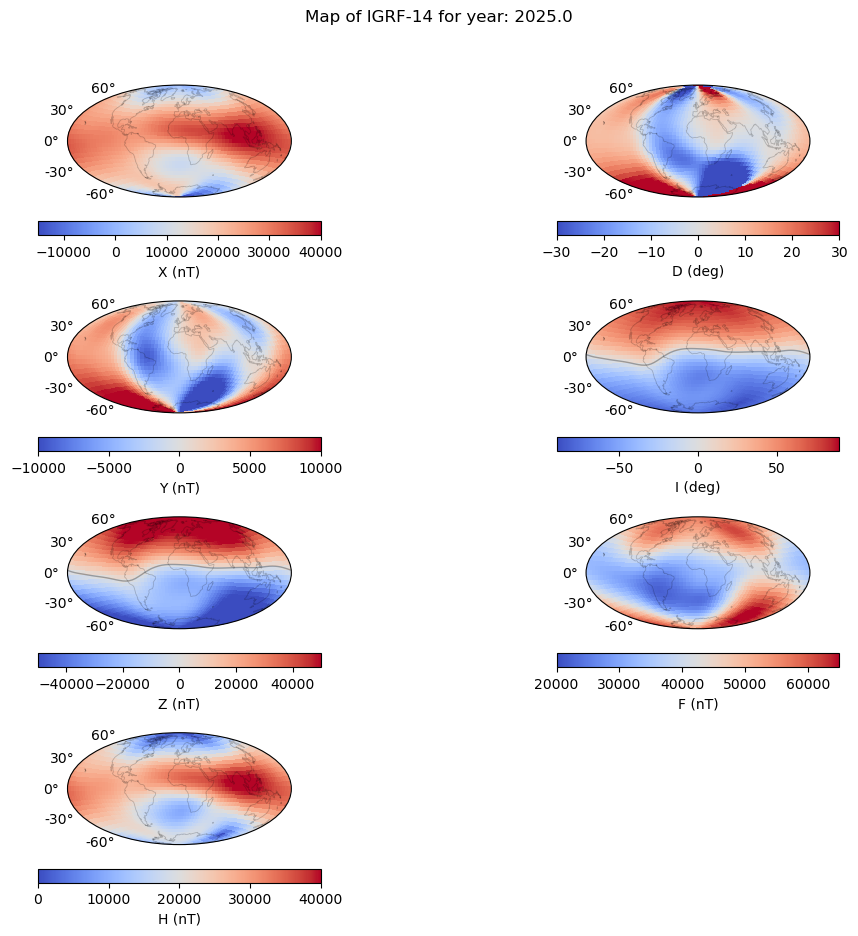

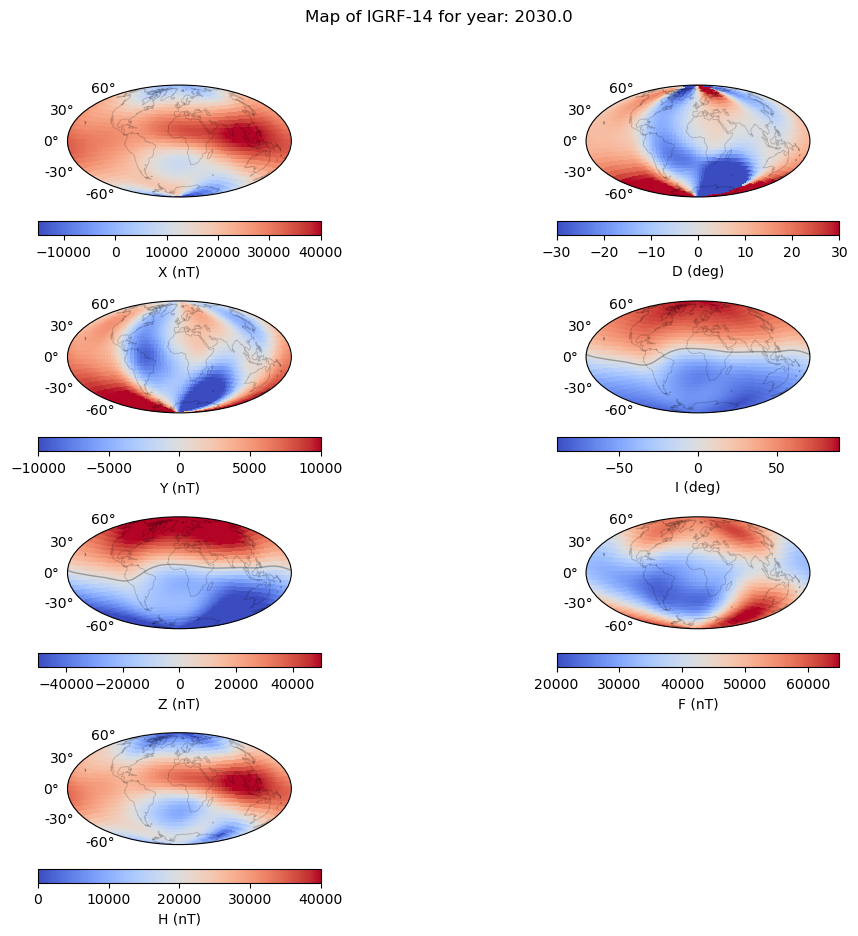

In [5]:
"""

Plot a series of maps showing the main field at 2020, 2025, 2030 and SV

Based on the example from
https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html

"""

components = ['X', 'D', 'Y', 'I', 'Z', 'F', 'H']    # Choose X, Y or Z, Br, Bt, Bp

# Define the contour levels to use in plt.contourf
contouring = {'Xmin': -15000, 'Xmax': 40000, 'Xcont':  5000, \
              'Ymin': -10000, 'Ymax': 10000, 'Ycont':  2500,\
              'Zmin': -50000, 'Zmax': 50000, 'Zcont': 10000,\
              'Dmin':    -30, 'Dmax':    30, 'Dcont':     5,\
              'Imin':    -90, 'Imax':    90, 'Icont':     5, \
              'Fmin':  20000, 'Fmax': 65000, 'Fcont':  5000,\
              'Hmin':      0, 'Hmax': 40000, 'Hcont':  5000,}


# Work out the best layout of the plots in a subfigure e.g. 4 x 4
# using the sqrt and remainder
nrows = 4
ncols = 2

# Set up a lat/long grid  every 5 degrees
num_lon = 73
num_lat = 35
longs  = np.linspace(-180, 180, num_lon)
lats   = np.linspace(-90, 90, num_lat)
RREF = 6371.2 # standard geomagnetic Earth radius (in km)

#Loop over all of the models
for gen in range(len(time)-3,len(time)): 
    # Define the figure and each axis for the 4 rows and 2 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': 'hammer'},
                            figsize=(11,9.5), squeeze=True)
    # axs is a 2 dimensional array of `GeoAxes`.  Flatten it into a 1-D array
    axs=axs.flatten()

    # Use an axis counter to ensure no gaps in the middle subplots
    axis_count = 0
    
    # D. Kerridge's code includes the monopole for SHA computation
    gh = np.append(0., coeffs[:,gen])

    # Compute the maps of differences and save to a dict for ease
    # of plotting an individual element
    Bx, By, Bz = zip(*[shal.shm_calculator(gh,degree,RREF, \
                                          90-lat,lon, \
                                          'Geocentric') \
                     for lat in lats for lon in longs])
    X = np.asarray(Bx).reshape(num_lat,num_lon)
    Y = np.asarray(By).reshape(num_lat,num_lon)
    Z = np.asarray(Bz).reshape(num_lat,num_lon)
    H = np.sqrt(X**2 + Y**2)

    elements={'X':X, 'D':np.rad2deg(np.arctan2(Y,X)), 'Y':Y,\
              'I':np.rad2deg(np.arctan2(Z,H)), 'Z':Z, \
              'F':np.sqrt(X**2 + Y**2 + Z**2), 'H':H}
    
    for j in range(len(components)):
        print('axes ' + str(axis_count) + ' ' + str(j) + ': ' + \
         components[j])

        # Filled colour plot
        cs=axs[axis_count].pcolormesh(np.radians(longs), np.radians(lats),
                                      elements[components[j]],
                                      cmap='coolwarm',
                                      vmin=contouring[components[j] + 'min'],
                                      vmax=contouring[components[j] + 'max'])
        # Add the zero contours
        if components[j] in list(['Z', 'I']):
            line_c = axs[axis_count].contour(np.radians(longs), np.radians(lats),
                                         elements[components[j]],
                                         levels=[0], alpha=0.3,
                                         colors=['black'], linewidths=1)

        # Title each subplot with the name of the model
        # axs[axis_count].set_title(components[j])

        # Draw the coastines for each subplot
        # read shape-file and plot coast lines
        with shapefile.Reader(shp) as sf:

            for rec in sf.shapeRecords():
                lon_coast = np.radians([point[0] for point in rec.shape.points[:]])
                lat_coast = np.radians([point[1] for point in rec.shape.points[:]])

                axs[axis_count].plot(lon_coast, lat_coast, color='k', linewidth=0.6, alpha=0.2)

        axs[axis_count].xaxis.set_ticks(np.radians(np.linspace(-180., 180., num=13)))  # meridians
        axs[axis_count].yaxis.set_ticks(np.radians(np.linspace(-60., 60., num=5)))  # parallels
        axs[axis_count].xaxis.set_major_formatter('')  # remove labels from meridians
        axs[axis_count].grid(False)

        axis_count += 1
        
        # Draw the colorbar
        if components[j] in list(['D', 'I']):
            cbar=fig.colorbar(cs,orientation='horizontal', 
                              label=components[j] + ' (deg)', shrink=0.6)
        else:
            cbar=fig.colorbar(cs,orientation='horizontal', 
                              label=components[j] + ' (nT)', shrink=0.6)
        
    plt.suptitle('Map of IGRF-14 for year: ' + str(time[gen]) )
    
    # Delete the unwanted axes
    fig.delaxes(axs[7])


    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.05, top=0.90, left=0.05, right=0.95,
                        wspace=0.1, hspace=0.35)

axes 0 0: X
axes 1 1: D
axes 2 2: Y


axes 3 3: I
axes 4 4: Z
axes 5 5: F
axes 6 6: H


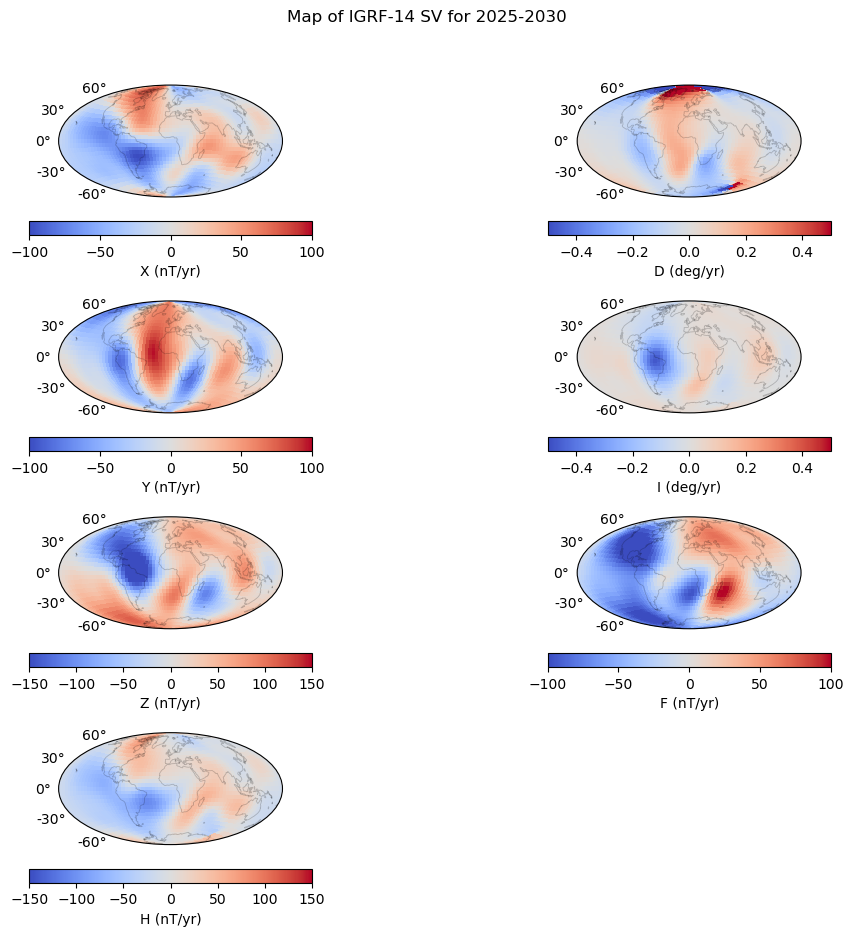

In [6]:

# Define the contour levels to use in plt.contourf
contouringsv = {'Xmin': -100, 'Xmax': 100, 'Xcont': 50, \
              'Ymin': -100, 'Ymax': 100, 'Ycont': 25,\
              'Zmin': -150, 'Zmax': 150, 'Zcont': 50,\
              'Dmin': -0.5, 'Dmax': 0.5, 'Dcont':  1,\
              'Imin': -0.5, 'Imax': 0.5, 'Icont':  1, \
              'Fmin': -100, 'Fmax': 100, 'Fcont': 50,\
              'Hmin': -150, 'Hmax': 150, 'Hcont': 50,}
    
# Define the figure and each axis for the 4 rows and 2 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': 'hammer'},
                        figsize=(11,9.5), squeeze=True)
# axs is a 2 dimensional array of `GeoAxes`.  Flatten it into a 1-D array
axs=axs.flatten()

# Use an axis counter to ensure no gaps in the middle subplots
axis_count = 0

# D. Kerridge's code includes the monopole for SHA computation
ghpast = np.append(0., (coeffs[:,-2]))
ghfuture = np.append(0., (coeffs[:,-1]))
# Compute the maps of differences and save to a dict for ease
# of plotting an individual element
Bxf, Byf, Bzf = zip(*[shal.shm_calculator(ghfuture,degree,RREF, \
                                      90-lat,lon, \
                                      'Geocentric') \
                 for lat in lats for lon in longs])
Bxp, Byp, Bzp = zip(*[shal.shm_calculator(ghpast,degree,RREF, \
                                      90-lat,lon, \
                                      'Geocentric') \
                 for lat in lats for lon in longs])

# Compute the SV values    
X = np.asarray(Bxp).reshape(num_lat,num_lon)
Y = np.asarray(Byp).reshape(num_lat,num_lon)
Z = np.asarray(Bzp).reshape(num_lat,num_lon)

Xdot = (np.asarray(Bxf).reshape(num_lat,num_lon)-np.asarray(Bxp).reshape(num_lat,num_lon))/5
Ydot = (np.asarray(Byf).reshape(num_lat,num_lon)-np.asarray(Byp).reshape(num_lat,num_lon))/5
Zdot = (np.asarray(Bzf).reshape(num_lat,num_lon)-np.asarray(Bzp).reshape(num_lat,num_lon))/5

Hsq = X**2 + Y**2
H = np.sqrt(Hsq)
Fsq = Hsq + Z**2
Hdot = (X*Xdot + Y*Ydot)/H


elements={'X':Xdot,'D':np.rad2deg((Ydot*X - Xdot*Y)/Hsq), \
          'Y':Ydot, \
          'I':np.rad2deg((H*Zdot - Hdot*Z)/Fsq), 'Z':Zdot,  \
          'F':(X*Xdot + Y*Ydot + Z*Zdot)/np.sqrt(Fsq), \
          'H':Hdot}
for j in range(len(components)):
    print('axes ' + str(axis_count) + ' ' + str(j) + ': ' + \
     components[j])

    # Filled colour plot
    cs=axs[axis_count].pcolormesh(np.radians(longs), np.radians(lats),
                                  elements[components[j]],
                                  cmap='coolwarm',
                                  vmin=contouringsv[components[j] + 'min'],
                                  vmax=contouringsv[components[j] + 'max'])


    # Title each subplot with the name of the model
    # axs[axis_count].set_title(components[j])

    # Draw the coastines for each subplot
    # read shape-file and plot coast lines
    with shapefile.Reader(shp) as sf:

        for rec in sf.shapeRecords():
            lon_coast = np.radians([point[0] for point in rec.shape.points[:]])
            lat_coast = np.radians([point[1] for point in rec.shape.points[:]])

            axs[axis_count].plot(lon_coast, lat_coast, color='k', linewidth=0.6, alpha=0.2)

    axs[axis_count].xaxis.set_ticks(np.radians(np.linspace(-180., 180., num=13)))  # meridians
    axs[axis_count].yaxis.set_ticks(np.radians(np.linspace(-60., 60., num=5)))  # parallels
    axs[axis_count].xaxis.set_major_formatter('')  # remove labels from meridians
    axs[axis_count].grid(False)

    axis_count += 1
    
    # Draw the colorbar
    if components[j] in list(['D', 'I']):
        cbar=fig.colorbar(cs,orientation='horizontal', 
                          label=components[j] + ' (deg/yr)', shrink=0.6)
    else:
        cbar=fig.colorbar(cs,orientation='horizontal', 
                          label=components[j] + ' (nT/yr)', shrink=0.6)
    
plt.suptitle('Map of IGRF-14 SV for 2025-2030 ')

# Delete the unwanted axes
fig.delaxes(axs[7])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.05, top=0.90, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.35)

## PLot the change in Dipole Moments over time

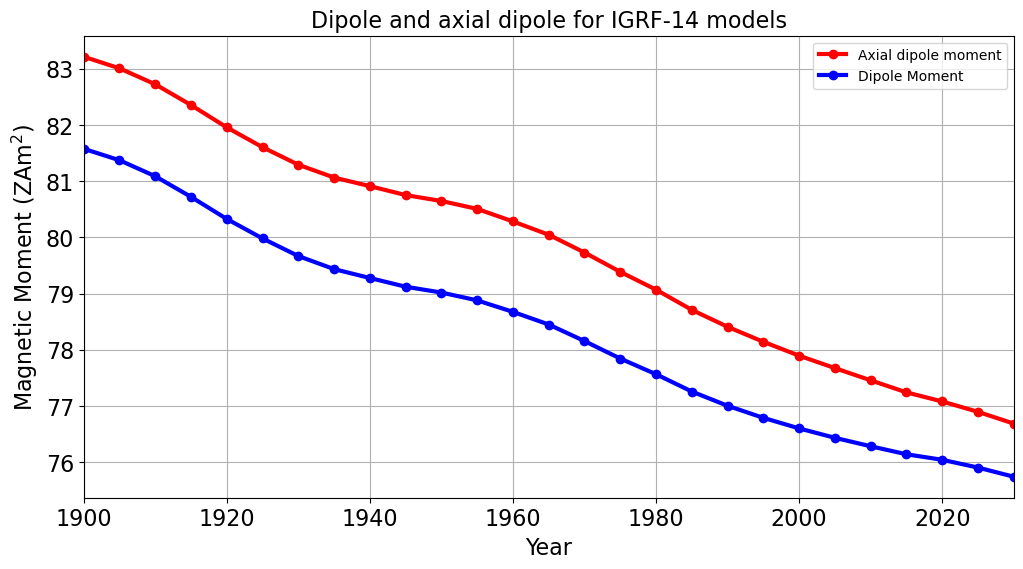

In [7]:

mu_0 = 4*np.pi*10**-7 # permeability of free space
a = 6371.200 # Earth radius in km
zetta = 10**21

M = []
M_A = []

for i in range(parameters['N']):
    M.append(4*np.pi/mu_0 * a**3 * np.sqrt(np.sum(coeffs[0:3,i]**2))/zetta)
    M_A.append(4*np.pi/mu_0 * a**3 * np.abs(coeffs[0,i])/zetta)
    
    
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(time, M, 'ro-', linewidth=3)
plt.plot(time, M_A, 'bo-', linewidth=3)

# Adding legend, x and y labels, and title for the lines
ax.legend({'Dipole Moment', 'Axial dipole moment'})
plt.xlabel('Year')
plt.ylabel('Magnetic Moment (ZAm$^2$)')
ax.grid()
plt.xticks(np.arange(parameters['start_year'], parameters['end_year'], 20))
plt.xlim([parameters['start_year'], parameters['end_year']])
plt.title('Dipole and axial dipole for IGRF-14 models')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)